In [28]:
import json
import os
import re
import traceback
import yaml
import random

import folium
import networkx as nx
import nx_arangodb as nxadb
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd

from arango import ArangoClient
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from IPython.display import Markdown, display

from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs import ArangoGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langgraph.prebuilt import create_react_agent

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

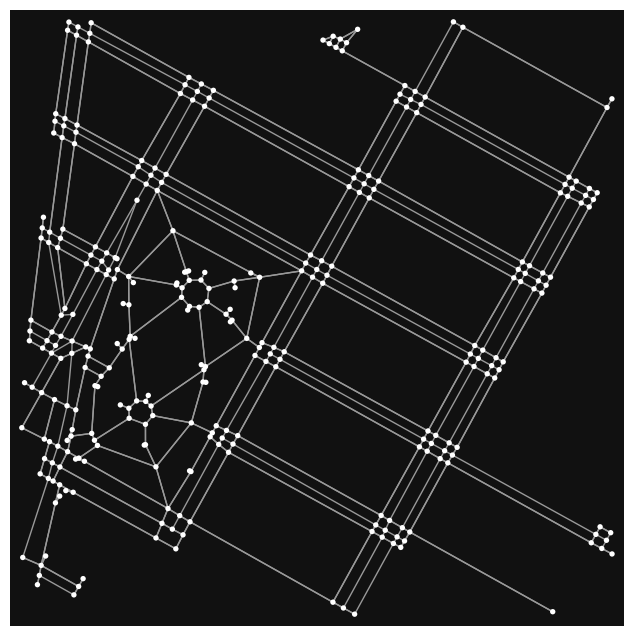

MultiDiGraph with 307 nodes and 865 edges


In [5]:
# Load street network graph from saved file
filepath = "./data/madison.graphml"
G_ox = ox.io.load_graphml(filepath)
ox.plot_graph(G_ox)
print(G_ox)


In [20]:
# Load credentials
credentials = yaml.load(open('credentials.yml'), Loader=yaml.SafeLoader)
os.environ["OPENAI_API_KEY"] = credentials["OPENAI_API_KEY"]

In [7]:
db = ArangoClient(hosts=credentials["DATABASE_HOST"]).db(
    username=credentials["DATABASE_USERNAME"],
    password=credentials["DATABASE_PASSWORD"],
    verify=True
)

In [8]:
G_ox_adb = nxadb.MultiDiGraph(
    name="G_ox_adb",
    db=db,
    incoming_graph_data=G_ox,
    overwrite_graph=True
)

[18:43:05 -0500] [INFO]: Overwriting graph 'G_ox_adb'
[18:43:05 -0500] [INFO]: Graph 'G_ox_adb' exists.
[18:43:05 -0500] [INFO]: Default node type set to 'G_ox_adb_node'
[2025/03/02 18:43:05 -0500] [72112] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/02 18:43:05 -0500] [72112] [INFO] - adbnx_adapter: Created ArangoDB 'G_ox_adb' Graph


In [9]:
# Retrieve OpenStreet map features within the area of the street network that we just received
# Refer to https://wiki.openstreetmap.org/wiki/Map_features for the specific features

# Collecting a large number of tags improves the diversity of queries we can make!

tags = {'building': True, 'amenity': True, 'healthcare': True, 'office': True, 'public_transport': True, 'craft': True, 'historic': True}
features_gdf = ox.features.features_from_address("1 Madison Ave, Manhattan, NY", tags, 240.0)

In [10]:
if db.has_collection('features'):
    db.delete_collection('features')
features_collection = db.create_collection('features')

# This is to avoid warnings given by geopandas regarding the centroid accuracy
# Some of the geometries in the GeoDataFrame returned by OSMNX are polygons 
# that give a bounding box for a particular feature

# To simplify the process so that each feature has an associated lat and long,
# we just return the centroid of the geometry instead
# e.g. for a bounding box, just return the center point 

utm_crs = ox.projection.project_gdf(features_gdf).crs
features_gdf['lat'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).y
features_gdf['lon'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).x

features_gdf_adjusted = features_gdf.drop(columns=['geometry','type'])

features_json_str = features_gdf_adjusted.reset_index().to_json(orient='records')
features_records = json.loads(features_json_str)

features_collection.insert_many(features_records)
print(f"Added {len(features_records)} feature records to ArangoDB 'features' collection")

Added 423 feature records to ArangoDB 'features' collection


In [11]:
# Initialize ArangoGraph
arango_graph = ArangoGraph(db)

In [12]:
@tool
def text_to_aql_to_text(query):
    """
    Translates natural language to AQL, executes against Arango database, returns results as text.
    
    USE THIS TOOL WHEN:
    - Querying the graph in ArangoDB (nodes, edges, features collections)
    - Finding relationships/paths between locations or buildings
    - Performing aggregations, filters, or sorting on stored data
    - Looking up properties like names, addresses, or building types
    - Counting or listing street network elements with specific attributes
    
    DO NOT USE WHEN:
    - Working with the in-memory OSMNX graph object
    - Calculating network metrics like centrality or clustering
    - Performing advanced spatial operations
    """
    print(f"🔍 AQL Tool: Starting to process query: '{query}'")
    
    # Initialize the LLM
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print(f"🔍 AQL Tool: Initialized LLM")
    
    # Build schema context dynamically
    schema_context = """
    You are an experienced graph network analyst proficient in writing ArangoDB Query Language. 

    This query is about data with these collections:
    
    1. G_ox_adb_node: Street intersections with attributes:
    - x, y: Coordinates (longitude, latitude)
    - osmid: OpenStreetMap ID
    - highway: Type of intersection (junction, traffic_signals, etc.)
    - address: Real world location of the node

    2. G_ox_adb_edge: Street segments connecting intersections
    - length: Distance in meters
    - name: Street name
    - oneway: Boolean indicating if it's a one-way street

    3. features: Features of the area with attributes:
    - osmid: OpenStreetMap ID
    - element_type: 'node' or 'way'
    - the following OpenStreetMap feature tags
        - building: either 'yes' or 'no' if the feature is a building
        - amenity: The type of amenity the feature is e.g. cafe, bank
        - healthcare: The health specialty e.g. nurse, optometrist
        - office: The type of company the office is for e.g. financial, airline
        - public_transport: The type of public transport feature e.g. platform, station
        - craft: Describes the type of craft the feature is for e.g. bakery, jeweller
        - historic: Describes the type of historic site, e.g. house, memorial
    - name: Name of the feature
    - lat, lon: geospatial coordinates of the feature

    If the query asks for a path to the nearest feature, first find a node on the graph that is closest to that feature, 
    then run the algorithm.

    If the query specifies a generic location type like 'cafe', 'office', 'subway' or 'bank', use the amenity attribute. 
    Use the other OpenStreetMap feature tags if the query is more specific.

    For example, if there is a building located at a certain latitude and longitude, and the query asks for a path to get to that building,
    first find a node in the graph that has the nearest straight line distance to that building, then use that node for the traversal algorithm.

    Focus on writing efficient AQL queries that:
    1. Use FILTER, SORT, LIMIT as needed to optimize performance
    2. Use graph traversals for finding paths and connections
    3. Return well-structured data that directly answers the question
    4. Include relevant coordinates and attributes in the results
    """

    # Graph context for better query translation
    context = schema_context
    enhanced_query = f"{context} Query: {query}"
    
    try:
        # Create and execute the chain
        chain = ArangoGraphQAChain.from_llm(
            llm=llm,
            graph=arango_graph,
            verbose=True,
            allow_dangerous_requests=True
        )
        
        print(f"🔍 AQL Tool: Executing query against ArangoDB")
        result = chain.invoke(enhanced_query)
        return str(result["result"])

    except Exception as e:
        print(f"🔍 AQL Tool: ERROR executing query: {str(e)}")
        print(f"🔍 AQL Tool: {traceback.format_exc()}")
        return f"Error executing the database query: {str(e)}"

In [13]:
@tool
def text_to_ox_algorithm_to_text(query):
    """
    Executes OSMnx/NetworkX algorithms on the in-memory street network graph.
    
    USE THIS TOOL WHEN:
    - Calculating network metrics (centrality, connectivity, clustering)
    - Finding paths using specialized algorithms
    - Analyzing network topology and structure
    - Performing spatial operations (nearest nodes, isochrones)
    - Computing network statistics or identifying critical components
    
    DO NOT USE WHEN:
    - Querying existing database records
    - Looking up specific street or building properties
    - Creating visualizations
    - Geocoding addresses
    """
    print(f"🚏 OSMNX Tool: Starting to process query: '{query}'")

    # Initialize LLM
    model_name = "gpt-4o"
    llm = ChatOpenAI(temperature=0, model_name=model_name)
    print(f"🚏 OSMNX Tool: Initialized LLM {model_name}")

    # Step 1: Generate OSMnx code
    print("🚏 OSMNX Tool: 1) Generating OSMnx code")
    
    code_generation_prompt = f"""
    You are an expert in network analysis using OSMnx and NetworkX. 
    I need you to translate a natural language query into precise Python code.
    
    # GRAPH SCHEMA
    I have an OSMnx Graph called `G_ox` with the following schema: {arango_graph.schema}
    
    # QUERY TO ANALYZE
    Natural language query: {query}
    
    # TASK
    Generate executable Python code to answer this query using NetworkX/OSMnx algorithms.
    
    # GRAPH DETAILS
    The `G_ox` graph is an in-memory OSMnx graph representing a street network with these characteristics:
    - Each node represents an intersection with geospatial coordinates
    - Each edge represents a street segment connecting intersections
    - Nodes have attributes like 'x' and 'y' coordinates, 'osmid', and sometimes 'address'
    - Edges have attributes like 'length', 'name', 'highway' type, and sometimes 'oneway'
    
    # ALGORITHM SELECTION GUIDELINES
    - For centrality: Use nx.betweenness_centrality(), nx.closeness_centrality(), or nx.degree_centrality()
    - For connectivity: Use nx.node_connectivity(), nx.edge_connectivity(), or nx.is_strongly_connected()
    - For clustering: Use nx.clustering(), or community detection algorithms
    - For shortest paths: Use nx.shortest_path(), nx.shortest_path_length(), or ox.distance.shortest_path()
    - For accessibility: Compute isochrones or service areas using nx.ego_graph() or custom functions
    - For statistics: Use ox.stats.basic_stats() or custom calculations
    
    # CODE STRUCTURE
    - Include descriptive variable names and brief comments
    - For node lookups by coordinates: Use `node_id = ox.distance.nearest_nodes(G_ox, lon, lat)`
    - For path finding between points: First find nearest nodes, then compute shortest path
    - Focus on the specific algorithm needed rather than general exploration
    - Set the final answer as `FINAL_RESULT` - this should be a CONCISE representation of the answer
    - For visualization queries or path analyses, include relevant coordinates in the result
    - Format results for human readability (round numbers, provide units, use descriptive labels)
    
    Only provide Python code that can be executed via `exec()`. No explanations or markdown.
    """

    text_to_ox = llm.invoke(code_generation_prompt).content
    text_to_ox_cleaned = re.sub(r"^```python\n|```$", "", text_to_ox, flags=re.MULTILINE).strip()
    
    print('🚏 OSMNX Tool: Generated code:')
    print('-'*50)
    print(text_to_ox_cleaned)
    print('-'*50)

    # Step 2: Execute OSMnx code
    print("\n🚏 OSMNX Tool: 2) Executing OSMnx code")
    global_vars = {"G_ox": G_ox, "ox": ox, "nx": nx, "pd": pd, "np": np}
    local_vars = {}

    try:
        exec(text_to_ox_cleaned, global_vars, local_vars)
        text_to_ox_final = text_to_ox_cleaned
        print("🚏 OSMNX Tool: Code executed successfully! ✅")
    except Exception as e:
        print(f"🚏 OSMNX Tool: EXEC ERROR: {str(e)} ❌")
        
        # Code correction mechanism
        MAX_ATTEMPTS = 3
        for attempt in range(1, MAX_ATTEMPTS + 1):
            print(f"🚏 OSMNX Tool: Attempting code correction: Attempt {attempt}/{MAX_ATTEMPTS}")
            
            correction_prompt = f"""
            The following OSMnx/NetworkX code failed with error: {str(e)}
            
            Original code:
            ```python
            {text_to_ox_cleaned}
            ```
            
            Fix the code to properly execute and answer the query: "{query}"
            
            Common issues to check:
            1. Node or edge access methods (G_ox.nodes vs G_ox.nodes() or attribute access)
            2. Parameter types or values (ensure coordinates are float, IDs are correct types)
            3. Missing error handling (add try/except for node lookups, path finding)
            4. Incorrect attribute names (verify the attributes actually exist in the graph)
            5. Algorithm parameter requirements (some functions need specific inputs)
            
            Provide only the corrected code, no explanations.
            """
            
            corrected_code = llm.invoke(correction_prompt).content
            corrected_code_cleaned = re.sub(r"^```python\n|```$", "", corrected_code, flags=re.MULTILINE).strip()
            
            print(f"🚏 OSMNX Tool: Corrected code (attempt {attempt}):")
            print('-'*50)
            print(corrected_code_cleaned)
            print('-'*50)
            
            try:
                exec(corrected_code_cleaned, global_vars, local_vars)
                text_to_ox_final = corrected_code_cleaned
                print(f"🚏 OSMNX Tool: Correction successful on attempt {attempt} ✅")
                break
            except Exception as e2:
                print(f"🚏 OSMNX Tool: Correction attempt {attempt} failed: {str(e2)} ❌")
                
                if attempt == MAX_ATTEMPTS:
                    error_msg = f"Unable to execute the OSMnx algorithm after {MAX_ATTEMPTS} attempts. Last error: {str(e2)}"
                    print(f"🚏 OSMNX Tool: {error_msg}")
                    return error_msg

    # Check if FINAL_RESULT exists in local_vars
    if "FINAL_RESULT" not in local_vars:
        error_msg = "Error: The code executed but did not set the FINAL_RESULT variable."
        print(f"🚏 OSMNX Tool: {error_msg} ❌")
        return error_msg
        
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print('🚏 OSMNX Tool: Execution completed with result:')
    print('-'*50)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*50)

    # Step 3: Formulate final answer
    print("🚏 OSMNX Tool: 3) Formulating final answer")
    
    natural_language_prompt = f"""
        # QUERY AND RESULTS
        Original query: "{query}"
        
        Analysis result: {FINAL_RESULT}
        
        # TASK
        Provide a clear, concise response that directly answers the original query based on the analysis result.
        
        Guidelines:
        - Explain what the result means in plain language
        - If the result is numeric, provide context for interpreting it
        - If the result identifies specific locations/streets, name them explicitly
        - For network metrics, explain their significance briefly (e.g., "high betweenness centrality means...")
        - If the result contains coordinates, format them clearly for potential visualization
        - Keep your response under 5 sentences unless complexity requires more
        - Do not mention the code or algorithms used unless specifically asked
        
        Your response:
    """

    ox_to_text = llm.invoke(natural_language_prompt).content
    print(f"🚏 OSMNX Tool: Final answer:")
    print('-'*50)
    print(ox_to_text)
    print('-'*50)
    print("🚏 OSMNX Tool: Processing complete ✅")

    return ox_to_text

In [14]:
@tool
def text_to_geocoder_to_coordinates(query):
    """
    Extracts location names from query, geocodes them, returns latitude and longitude values.
    
    USE THIS TOOL WHEN:
    - A specific location name is mentioned in the query and geospatial coordinates are required

    DO NOT USE THIS TOOL WHEN:
    - Unspecific location names like 'cafe' or 'park' are named in the query
    """
    print(f"📍 GEOCODING: Processing query: '{query}'")
    
    # Initialize services
    geolocator = Nominatim(user_agent="react_agent_geocoder")
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    
    # Extract location entities using LLM
    location_extraction_prompt = """
    Extract all location names from the following query. 
    Include cities, addresses, landmarks, neighborhoods, regions, or any other geographic references.
    Return ONLY the location names separated by semicolons.
    If no locations are found, return "NO_LOCATION".
    
    Query: {query}
    
    Location names:
    """
    
    location_extraction = llm.invoke(location_extraction_prompt.format(query=query)).content
    
    # Process extracted locations
    possible_locations = [loc.strip() for loc in location_extraction.split(";")] if location_extraction and location_extraction != "NO_LOCATION" else [query]
    print(f"📍 GEOCODING: Extracted locations: {possible_locations}")
    
    # Process locations
    results = []
    for location in possible_locations:
        try:
            geocode_result = geolocator.geocode(location, exactly_one=True, language="en")
            
            if geocode_result:
                print(f"📍 GEOCODING: Found {location} at {geocode_result.latitude}, {geocode_result.longitude}")
                results.append({
                    "query_text": location,
                    "geocoded": {
                        "name": geocode_result.address,
                        "lat": geocode_result.latitude,
                        "lon": geocode_result.longitude
                    }
                })
        except Exception as e:
            print(f"📍 GEOCODING: Error with {location}: {str(e)}")
            continue
    
    # Try suggestion if no results found
    if not results:
        suggestion_prompt = """
        I could not geocode any locations from the query: "{query}"
        Suggest a better location reference or return "NO_SUGGESTION".
        """
        
        suggestion = llm.invoke(suggestion_prompt.format(query=query)).content
        
        if suggestion and suggestion != "NO_SUGGESTION":
            try:
                geocode_result = geolocator.geocode(suggestion, exactly_one=True, language="en")
                if geocode_result:
                    results.append({
                        "query_text": suggestion,
                        "geocoded": {
                            "name": geocode_result.address,
                            "lat": geocode_result.latitude,
                            "lon": geocode_result.longitude
                        }
                    })
            except Exception:
                pass
    
    # Return error if no results found
    if not results:
        return {
            "success": False,
            "error": "Could not geocode any locations from the query",
            "query": query
        }
    
    # Determine primary location
    primary_result = results[0]
    if len(results) > 1:
        location_names = [r["geocoded"]["name"] for r in results]
        primary_prompt = """
        Which ONE location is the primary focus of this query: "{query}"
        Locations: {locations}
        Return ONLY the name of the primary location.
        """
        
        primary_name = llm.invoke(primary_prompt.format(
            query=query,
            locations=', '.join(location_names)
        )).content
        
        # Find closest match
        for result in results:
            if primary_name.lower() in result["geocoded"]["name"].lower():
                primary_result = result
                break
    
    print(f"📍 GEOCODING: Primary location: {primary_result['geocoded']['name']}")
    
    return {
        "success": True,
        "locations": results,
        "primary_location": primary_result["geocoded"],
        "query": query
    }

In [15]:
@tool
def text_to_folium_visualization(query):
    """
    Visualize coordinates extracted from a query on a Folium map in a Jupyter notebook.
    
    This tool uses an LLM to extract coordinate information from the query text
    and displays the points on an interactive map.
    
    Args:
        query: Text describing coordinates to visualize
    """
    import folium
    import pandas as pd
    from langchain_openai import ChatOpenAI
    import json
    import re
    from IPython.display import display
    
    print(f"🌎 VISUALIZATION: Starting to process query: '{query}'")
    
    # Initialize LLM for coordinate extraction
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    print("🌎 VISUALIZATION: Initialized ChatOpenAI for coordinate extraction")
    
    # Extract coordinates using LLM
    extraction_prompt = f"""
    Extract all geographic coordinates from the following text.
    Return ONLY a JSON array of objects with 'lat' and 'lon' properties.
    If a location name is mentioned instead of coordinates, do not include it.
    Only include explicitly mentioned coordinates.
    
    Example valid response:
    [
      {{"lat": 40.7411, "lon": -73.9897, "name": "Madison Square Park"}},
      {{"lat": 40.7128, "lon": -74.0060}}
    ]
    
    If you can identify names for the points, include them as a "name" property.
    If no coordinates are found, return an empty array: []
    
    Text: {query}
    
    JSON array:
    """
    
    print("🌎 VISUALIZATION: Sending coordinate extraction prompt to LLM")
    
    # Get coordinates from LLM
    extraction_result = llm.invoke(extraction_prompt).content
    print(f"🌎 VISUALIZATION: Received extraction result from LLM")
    
    # Clean up the response to ensure it's valid JSON
    # Sometimes the LLM adds text before or after the JSON array
    json_match = re.search(r'\[\s*\{.*\}\s*\]', extraction_result, re.DOTALL)
    if json_match:
        clean_json = json_match.group(0)
    else:
        clean_json = extraction_result
        
    # Parse the JSON response
    try:
        coordinates_list = json.loads(clean_json)
        print(f"🌎 VISUALIZATION: Successfully parsed JSON response")
    except json.JSONDecodeError as e:
        print(f"🌎 VISUALIZATION: Error parsing JSON response: {str(e)}")
        error_msg = "Failed to extract coordinates from the query. Please provide coordinates in a clear format."
        print(f"🌎 VISUALIZATION: Error - {error_msg}")
        return error_msg
    
    # Validate extracted coordinates
    if not coordinates_list:
        error_msg = "No coordinates found in the query. Please provide coordinates in formats like '40.7411, -73.9897' or 'latitude 40.7411 longitude -73.9897'."
        print(f"🌎 VISUALIZATION: Error - {error_msg}")
        return error_msg
    
    print(f"🌎 VISUALIZATION: Extracted {len(coordinates_list)} coordinate pairs from query")
    
    # Create a DataFrame from the coordinates
    df = pd.DataFrame(coordinates_list)
    
    # Create a unique variable name for the map
    map_var_name = f"folium_map_{id(df)}"
    
    print("🌎 VISUALIZATION: Creating dark-themed Folium map")
    
    # Create the Folium map - dark theme, no center point
    globals()[map_var_name] = folium.Map(tiles="Cartodb dark_matter")
    
    # Add the markers to the map
    for point in coordinates_list:
        popup_text = point.get('name', f"Lat: {point['lat']}, Lon: {point['lon']}")
        folium.Marker(
            location=[point['lat'], point['lon']],
            popup=popup_text,
            tooltip=popup_text
        ).add_to(globals()[map_var_name])
    
    # Fit bounds to include all markers
    if coordinates_list:
        lats = [point['lat'] for point in coordinates_list]
        lons = [point['lon'] for point in coordinates_list]
        globals()[map_var_name].fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
    
    # Log each point for reference
    print(f"🌎 VISUALIZATION: Points being displayed:")
    for i, point in enumerate(coordinates_list):
        point_desc = f"Point {i+1}: lat={point['lat']}, lon={point['lon']}"
        if 'name' in point:
            point_desc += f", name='{point['name']}'"
        print(f"🌎 VISUALIZATION:   - {point_desc}")
    
    # Return confirmation and instructions
    print(f"🌎 VISUALIZATION: Successfully created map with {len(coordinates_list)} points")
    print(f"🌎 VISUALIZATION: Map available as variable '{map_var_name}'")
    
    # Display the map directly in the notebook
    display(globals()[map_var_name])
    
    return f"Map with {len(coordinates_list)} points created and displayed. The map is also available as the '{map_var_name}' variable."

In [23]:
def query_graph(query, display_result=True):
    """
    Main function to process graph queries using the agent with the tools defined above.
    
    Args:
        query: Natural language query about the street network
        display_result: Whether to display the result as Markdown (default: True)
        
    Returns:
        None if display_result is True, otherwise returns the raw response string
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    
    # We want tools to be able to transfer results between them, so we keep track of the 
    # results generated by each tool as the agent steps through them

    # Track tool results
    tool_results = {}
    
    # Create wrapped versions of tools
    tools_list = [text_to_aql_to_text, text_to_ox_algorithm_to_text, text_to_geocoder_to_coordinates, text_to_folium_visualization]
    wrapped_tools = []
    
    for tool in tools_list:
        def wrapped_tool_fn(input_str, _tool=tool):
            # Check if input references previous results
            modified_input = input_str
            for tool_name, result in tool_results.items():
                placeholder = f"USE_PREVIOUS_RESULT[{tool_name}]"
                if placeholder in modified_input:
                    modified_input = modified_input.replace(placeholder, result)
            
            # Execute the tool with potentially modified input
            result = _tool.invoke(modified_input)
            
            # Store the result for future use
            tool_results[_tool.name] = result
            
            return result
        
        # Create a new tool with the wrapped function
        wrapped_tool = Tool(
            name=tool.name,
            description=tool.description + "\nYou can refer to results from other tools using USE_PREVIOUS_RESULT[tool_name].",
            func=wrapped_tool_fn
        )
        
        wrapped_tools.append(wrapped_tool)
    
    # Create the React agent with wrapped tools
    app = create_react_agent(llm, wrapped_tools)
    
    # Add a system message explaining the ability to use previous results
    system_message = SystemMessage(content="""
        You have access to multiple tools and can use the results of previous tool calls in new ones.
        To use a previous result, include USE_PREVIOUS_RESULT[tool_name] in your action input.
        For example:
        Action: text_to_ox_algorithm_to_text
        Action Input: Analyze the graph from USE_PREVIOUS_RESULT[text_to_aql_to_text] using Djikstra's algorithm.

        When passing results from a previous entry to the visualization tool, make sure you include all relevant coordinates
        from the previous tool's results.
        """)
    
    initial_state = {"messages": [system_message, HumanMessage(content=query)]}
    
    # Run the agent
    final_state = app.invoke(initial_state)
    response = final_state["messages"][-1].content
    
    if display_result:
        display(Markdown(f"{response}"))
        return None
    else:
        # Return the raw string if needed for further processing
        return response

In [36]:
query_graph("Identify all of the pharmacies around Madison Square Park and give me the shortest path to the nearest one.")

📍 GEOCODING: Processing query: 'Madison Square Park, New York'
📍 GEOCODING: Extracted locations: ['Madison Square Park', 'New York']
📍 GEOCODING: Found Madison Square Park at 40.742203, -73.9879654739484
📍 GEOCODING: Found New York at 40.7127281, -74.0060152
📍 GEOCODING: Primary location: Madison Square Park, 11, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States
🔍 AQL Tool: Starting to process query: 'Find all pharmacies around Madison Square Park within a 1 km radius.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, features
FOR feature IN features
  FILTER feature.amenity == "pharmacy"
  LET distance = GEO_DISTANCE([feature.lon, feature.lat], [-73.9876, 40.7420]) // Coordinates for Madison Square Park
  FILTER distance <= 1000
  RETURN {
    name: feature.name,
    address: feature['addr:street'],
    distance: distance,
    coordinates: {
   

The nearest pharmacy to Madison Square Park is Duane Reade, located approximately 326 meters away on Park Avenue South. The shortest path from Madison Square Park to this pharmacy covers a distance of about 459.53 meters. This route is optimal for minimizing travel distance, making it convenient for pedestrians or cyclists.

In [33]:
query_graph("What types of buildings are most common in the area around Madison Avenue?")

📍 GEOCODING: Processing query: 'Madison Avenue'
📍 GEOCODING: Extracted locations: ['Madison Avenue']
📍 GEOCODING: Found Madison Avenue at 40.758401468117846, -73.97519690653264
📍 GEOCODING: Primary location: Madison Avenue, Midtown East, Manhattan Community Board 5, Manhattan, New York County, New York, 10037, United States
🔍 AQL Tool: Starting to process query: 'Find the most common types of buildings around the coordinates 40.7584, -73.9752 within a 500-meter radius.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH features
FOR feature IN features
  FILTER feature.building == 'yes'
  FILTER GEO_DISTANCE([feature.lon, feature.lat], [-73.9752, 40.7584]) <= 500
  COLLECT buildingType = feature.building WITH COUNT INTO count
  SORT count DESC
  RETURN { buildingType, count }

AQL Result:
[]

> Finished chain.


It seems that there are no building records available in the database for the area around Madison Avenue within a 500-meter radius. This might be due to a lack of data coverage for that specific location. If you have any other questions or need further assistance, feel free to ask!

In [34]:
query_graph("Find all buildings within 100 meters of the most central intersection.")

🚏 OSMNX Tool: Starting to process query: 'Find the most central intersection in the street network using closeness centrality.'
🚏 OSMNX Tool: Initialized LLM gpt-4o
🚏 OSMNX Tool: 1) Generating OSMnx code
🚏 OSMNX Tool: Generated code:
--------------------------------------------------
import networkx as nx
import osmnx as ox

# Calculate closeness centrality for each node in the graph
closeness_centrality = nx.closeness_centrality(G_ox)

# Find the node with the highest closeness centrality
most_central_node = max(closeness_centrality, key=closeness_centrality.get)

# Retrieve the coordinates of the most central node
most_central_node_coords = (G_ox.nodes[most_central_node]['x'], G_ox.nodes[most_central_node]['y'])

# Prepare the final result
FINAL_RESULT = {
    'most_central_node': most_central_node,
    'closeness_centrality': round(closeness_centrality[most_central_node], 4),
    'coordinates': most_central_node_coords
}

# Print the final result
print(FINAL_RESULT)
----------------

Here are the buildings within 100 meters of the most central intersection at coordinates (-73.9867434, 40.7427614):

1. **60 Madison**
   - Coordinates: (-73.9864111, 40.743083)
   - Distance: 38.08 meters

2. **New York Life Building**
   - Coordinates: (-73.9855821838, 40.742746413)
   - Distance: 85.60 meters

3. **Merchandise Mart Building**
   - Coordinates: (-73.9862646321, 40.742353282)
   - Distance: 54.28 meters

4. **Merchandise Mart Building** (another instance)
   - Coordinates: (-73.9862646321, 40.742353282)
   - Distance: 69.24 meters

Additionally, there are several unnamed features located at various distances ranging from approximately 29.15 meters to 95.35 meters from the intersection.

In [37]:
query_graph("Which cafes have the best accessibility based on the street network? Visualize them.")

🔍 AQL Tool: Starting to process query: 'List all cafes with their accessibility scores based on the street network.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH features, G_ox_adb_node, G_ox_adb_node_to_G_ox_adb_node

FOR cafe IN features
    FILTER cafe.amenity == "cafe"
    LET nearestNode = (
        FOR node IN G_ox_adb_node
            SORT GEO_DISTANCE([cafe.lon, cafe.lat], [node.x, node.y]) ASC
            LIMIT 1
            RETURN node
    )[0]
    LET accessibilityScore = (
        FOR v, e, p IN 1..5 OUTBOUND nearestNode G_ox_adb_node_to_G_ox_adb_node
            FILTER e.oneway == false
            COLLECT WITH COUNT INTO length
            RETURN length
    )
    RETURN {
        cafeName: cafe.name,
        cafeLocation: { lat: cafe.lat, lon: cafe.lon },
        nearestNode: nearestNode._id,
        accessibilityScore: accessibilityScore
    }

AQL Result:
[{'cafeName': 'Broadway

I have visualized the cafes with their accessibility scores on a map. You can view the map to see the locations and their respective scores. The cafes with higher scores are more accessible based on the street network.

In [40]:
query_graph("I would like to visit a pharmacy after leaving the Flatiron Building, what's the nearest pharmacy to that building, and afterwards, what's the shortest path I can walk from that pharmacy to the national museum of mathematics?")

📍 GEOCODING: Processing query: 'Flatiron Building, New York'
📍 GEOCODING: Extracted locations: ['Flatiron Building', 'New York']
📍 GEOCODING: Found Flatiron Building at 40.741059199999995, -73.98964162240998
📍 GEOCODING: Found New York at 40.7127281, -74.0060152
📍 GEOCODING: Primary location: Flatiron Building, 175, 5th Avenue, Flatiron District, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States
🚏 OSMNX Tool: Starting to process query: 'Find the nearest pharmacy to the coordinates 40.741059199999995, -73.98964162240998.'
📍 GEOCODING: Processing query: 'national museum of mathematics, New York'
🚏 OSMNX Tool: Initialized LLM gpt-4o
🚏 OSMNX Tool: 1) Generating OSMnx code
📍 GEOCODING: Extracted locations: ['National Museum of Mathematics', 'New York']
📍 GEOCODING: Found National Museum of Mathematics at 40.7435852, -73.9877866
📍 GEOCODING: Found New York at 40.7127281, -74.0060152
📍 GEOCODING: Primary location: National Museum of Mathematics, 225, 5th 

It seems that there are no pharmacies found near the Flatiron Building based on the available data. However, I have the coordinates for the National Museum of Mathematics:

- **National Museum of Mathematics**: 40.7435852, -73.9877866

If you have a specific pharmacy in mind or another location, please let me know, and I can help find the shortest path from there to the museum. Alternatively, you might want to use a local map service to find nearby pharmacies.

In [42]:
query_graph("Describe the relationship between building heights and street connectivity in this street network.")

🔍 AQL Tool: Starting to process query: 'Retrieve the building heights from the database.'🚏 OSMNX Tool: Starting to process query: 'Calculate street connectivity metrics such as node degree, edge density, and average node connectivity.'

🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB
🚏 OSMNX Tool: Initialized LLM gpt-4o
🚏 OSMNX Tool: 1) Generating OSMnx code


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH features
FOR feature IN features
FILTER feature.building == 'yes'
RETURN { name: feature.name, height: feature.height }

AQL Result:
[{'name': 'Cross Chambers', 'height': None}, {'name': '60 Madison', 'height': None}, {'name': 'The Grand Madison', 'height': '50.1'}, {'name': None, 'height': '18.8'}, {'name': None, 'height': '19.9'}, {'name': None, 'height': '46.2'}, {'name': 'St. James Building', 'height': '68.1'}, {'name': 'New York Life Building', 'height': '22'}, {'name': 'Metropolitan Life Insurance Company Tower', 'height': None}, {'name'

The analysis of the street network and building heights provides the following insights:

1. **Building Heights**: The database contains information on various buildings, with some having specified heights. For example, "The Grand Madison" is 50.1 meters tall, "St. James Building" is 68.1 meters, and "Met Life Tower" is 150 meters. However, several buildings either lack names or have unspecified heights.

2. **Street Connectivity**: The street network analysis shows:
   - **Average Node Degree**: 5.64, indicating that each intersection connects to about 5 to 6 other streets on average.
   - **Edge Density**: 0.0092, suggesting a sparse network with a small fraction of possible connections between nodes.
   - **Average Node Connectivity**: 2.07, meaning there are typically just over two alternative paths between any two nodes.

### Relationship Analysis

- **Moderate Connectivity**: The moderately connected street network, with an average node degree of 5.64, suggests that the network is not highly dense. This can impact how easily people can move through the area, potentially affecting the desirability and value of taller buildings, which often rely on good accessibility.

- **Sparse Network**: The low edge density indicates that the network is not fully utilized, which might limit the potential for high-rise development unless connectivity is improved.

- **Building Heights and Accessibility**: Taller buildings like the "Met Life Tower" may benefit from improved street connectivity to enhance accessibility and traffic flow, which is crucial for commercial and residential attractiveness.

In summary, while the street network shows moderate connectivity, enhancing this could support the development and functionality of taller buildings by improving accessibility and traffic flow.